### 1. Main objective

Objective: Segment customers into distinct, behaviorally meaningful groups using clustering (unsupervised learning).
Business benefit: Customer churn is costly; segmentation helps stakeholders (CDO / Head of Analytics / Marketing / Retention) design targeted retention programs (e.g., proactive outreach for high-risk segments, bundling offers for high-usage segments, simplifying plans for low-engagement segments).

Important note: Although the dataset includes a churn column, the clustering model will be trained without using churn (since churn is a label). We’ll use churn only afterward to interpret clusters and quantify which segments exhibit higher churn risk.

### 2. Dataset description

Dataset: Customer Churn Data (200 rows, 28 numeric columns; all float64).
	•	Customer attributes: tenure, age, address, income, ed, employ, etc.
	•	Service / product indicators (binary-like): voice, pager, internet, callcard, wireless, ebill, etc.
	•	Usage & spend: longmon, tollmon, equipmon, cardmon, wiremon, plus “tenure totals” longten, tollten, cardten
	•	Derived log features already provided: loglong, logtoll, lninc
	•	Business category: custcat (likely 1–4)
	•	Outcome label (not used for training): churn (0/1)

Goal of analysis: Find clusters that differ by engagement, services owned, spend patterns, and tenure—then assess how churn rates differ across clusters.

### 3. Load + quick audit 

In [1]:
# 0.1: Install and import libraries
%pip install -q scikit-learn requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
import requests

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay
)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import requests
from io import StringIO

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/" \
      "IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/ChurnData.csv"

response = requests.get(url, verify=False)
churn_df = pd.read_csv(StringIO(response.text))

print(churn_df.shape)
display(churn_df.head())
churn_df.info()
display(churn_df.describe().T)

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


(200, 28)


,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

,count,mean,std,min,25%,50%,75%,max
tenure,200.0,35.505000,21.640971,1.000,16.75000,33.500,55.2500,72.000
age,200.0,41.165000,13.076803,19.000,31.00000,40.000,51.0000,76.000
address,200.0,11.650000,10.158419,0.000,3.00000,9.000,18.0000,48.000
income,200.0,75.130000,128.430468,9.000,31.00000,48.000,80.0000,1668.000
ed,200.0,2.825000,1.285550,1.000,2.00000,3.000,4.0000,5.000
employ,200.0,10.225000,8.957430,0.000,3.00000,7.500,17.0000,44.000
equip,200.0,0.425000,0.495584,0.000,0.00000,0.000,1.0000,1.000
callcard,200.0,0.705000,0.457187,0.000,0.00000,1.000,1.0000,1.000
wireless,200.0,0.290000,0.454901,0.000,0.00000,0.000,1.0000,1.000
longmon,200.0,11.789250,9.887250,1.100,5.53750,8.250,14.3000,62.300


### 4. Data exploration + cleaning / feature engineering

What we check and why

	•	Missing values: none reported, but we verify.

	•	Duplicates: unlikely but check.

	•	Skew/outliers: income has a very large max (1668 vs median 48), which can dominate distance-based clustering.

	•	Scaling: clustering is sensitive to feature scales → we standardize numeric features.

	•	Feature choice: income is highly skewed, and the dataset already includes lninc; similarly for long distance and toll usage (loglong, logtoll). To reduce outlier influence, we’ll prefer log features and drop some raw skewed ones.

### 4.1. Code: sanity checks + feature decisions

In [ ]:
# Basic checks
print("Missing values per column:\n", churn_df.isna().sum().sort_values(ascending=False).head(10))
print("Duplicate rows:", churn_df.duplicated().sum())

# Keep churn only for evaluation/interpretation (NOT training)
y_churn = churn_df["churn"].astype(int)

# Candidate feature set for clustering (exclude churn label)
# Option: replace skewed raw columns with provided log versions
drop_cols = ["churn"]  # label

# Because lninc/loglong/logtoll already exist, we can drop raw versions to reduce skew dominance.
drop_optional = ["income", "longmon", "tollmon"]  # use lninc/loglong/logtoll instead

X = churn_df.drop(columns=drop_cols)
X_reduced_skew = X.drop(columns=[c for c in drop_optional if c in X.columns])

print("Features used (reduced skew):", X_reduced_skew.shape[1])

Missing values per column:
 tenure      0
age         0
custcat     0
lninc       0
logtoll     0
loglong     0
ebill       0
confer      0
callwait    0
internet    0
dtype: int64
Duplicate rows: 0
Features used (reduced skew): 24


### 5. Preprocessing pipeline

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preprocess = Pipeline(steps=[
    ("scaler", StandardScaler())
])

X_scaled = preprocess.fit_transform(X_reduced_skew)

### 6. Train three unsupervised model variations

We’ll train and compare:

	1.	K-Means (vary K)

	2.	Gaussian Mixture Model (GMM; vary components, allows soft clustering)

	3.	Agglomerative (Hierarchical) Clustering (vary linkage)

We’ll evaluate using:

	•	Silhouette Score (higher is better; needs >1 cluster)

	•	Calinski-Harabasz Index (higher is better)
	
	•	Davies-Bouldin Index (lower is better)


### 6.1. Shared evaluation helpers

In [4]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def cluster_metrics(X, labels):
    # Handle edge cases (e.g., all in one cluster)
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        return {"n_clusters": n_clusters, "silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan}

    return {
        "n_clusters": n_clusters,
        "silhouette": silhouette_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels)
    }

### 6.2. Variation 1: K-Means

In [5]:
from sklearn.cluster import KMeans

kmeans_results = []
for k in range(2, 9):
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    m = cluster_metrics(X_scaled, labels)
    m.update({"model": "KMeans", "param": f"k={k}"})
    kmeans_results.append(m)

kmeans_results_df = pd.DataFrame(kmeans_results).sort_values(by="silhouette", ascending=False)
display(kmeans_results_df)

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,model,param
0,2,0.221201,45.806023,1.746729,KMeans,k=2
1,3,0.199625,47.771554,1.702066,KMeans,k=3
2,4,0.164041,41.081775,1.755946,KMeans,k=4
4,6,0.148371,30.918037,1.794815,KMeans,k=6
6,8,0.148361,28.310475,1.845077,KMeans,k=8
3,5,0.145748,34.231603,1.873263,KMeans,k=5
5,7,0.137874,28.266515,1.886820,KMeans,k=7


### 6.3. Variation 2: Gaussian Mixture Model (GMM)

In [6]:
from sklearn.mixture import GaussianMixture

gmm_results = []
for k in range(2, 9):
    model = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    labels = model.fit_predict(X_scaled)
    m = cluster_metrics(X_scaled, labels)
    m.update({"model": "GMM", "param": f"n_components={k}"})
    gmm_results.append(m)

gmm_results_df = pd.DataFrame(gmm_results).sort_values(by="silhouette", ascending=False)
display(gmm_results_df)

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,model,param
0,2,0.211668,44.882586,1.831049,GMM,n_components=2
1,3,0.197130,47.071914,1.722689,GMM,n_components=3
6,8,0.148436,28.306707,1.841351,GMM,n_components=8
2,4,0.145129,36.868440,1.845718,GMM,n_components=4
5,7,0.137841,28.261499,1.887828,GMM,n_components=7
3,5,0.124450,28.743980,2.020498,GMM,n_components=5
4,6,0.123764,26.178875,1.930272,GMM,n_components=6


### 6.4. Variation 3: Hierarchical / Agglomerative clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering

agg_results = []
for linkage in ["ward", "complete", "average"]:
    # ward requires euclidean distance and generally works well with standardized continuous data
    for k in range(2, 9):
        if linkage == "ward":
            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
        else:
            model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model.fit_predict(X_scaled)
        m = cluster_metrics(X_scaled, labels)
        m.update({"model": "Agglomerative", "param": f"linkage={linkage}, k={k}"})
        agg_results.append(m)

agg_results_df = pd.DataFrame(agg_results).sort_values(by="silhouette", ascending=False)
display(agg_results_df)

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,model,param
14,2,0.383975,4.251968,0.469283,Agglomerative,"linkage=average, k=2"
15,3,0.298231,8.225770,0.973010,Agglomerative,"linkage=average, k=3"
16,4,0.242492,6.293950,0.844994,Agglomerative,"linkage=average, k=4"
0,2,0.222831,42.511501,1.605943,Agglomerative,"linkage=ward, k=2"
1,3,0.182431,44.081509,1.812213,Agglomerative,"linkage=ward, k=3"
9,4,0.178224,31.257533,1.412964,Agglomerative,"linkage=complete, k=4"
10,5,0.164863,25.747571,1.429416,Agglomerative,"linkage=complete, k=5"
19,7,0.162111,12.875287,0.926540,Agglomerative,"linkage=average, k=7"
11,6,0.156404,22.989653,1.445913,Agglomerative,"linkage=complete, k=6"
20,8,0.151954,11.343897,0.840998,Agglomerative,"linkage=average, k=8"


### 6.5. Compare all models together

In [8]:
all_results_df = pd.concat([kmeans_results_df, gmm_results_df, agg_results_df], ignore_index=True)
all_results_df = all_results_df.sort_values(by=["silhouette", "calinski_harabasz"], ascending=[False, False])
display(all_results_df.head(15))

,n_clusters,silhouette,calinski_harabasz,davies_bouldin,model,param
14,2,0.383975,4.251968,0.469283,Agglomerative,"linkage=average, k=2"
15,3,0.298231,8.225770,0.973010,Agglomerative,"linkage=average, k=3"
16,4,0.242492,6.293950,0.844994,Agglomerative,"linkage=average, k=4"
17,2,0.222831,42.511501,1.605943,Agglomerative,"linkage=ward, k=2"
0,2,0.221201,45.806023,1.746729,KMeans,k=2
7,2,0.211668,44.882586,1.831049,GMM,n_components=2
1,3,0.199625,47.771554,1.702066,KMeans,k=3
8,3,0.197130,47.071914,1.722689,GMM,n_components=3
18,3,0.182431,44.081509,1.812213,Agglomerative,"linkage=ward, k=3"
19,4,0.178224,31.257533,1.412964,Agglomerative,"linkage=complete, k=4"


### 7. Pick a final model + explain recommendation

Recommendation logic (Report-ready)

We recommend the final model based on:

	•	Strong internal validation (silhouette, CH, DB)

	•	Cluster interpretability (clear differences in spend/usage/service ownership)
	
	•	Practical usability (stable segmentation; not too many clusters)

### 7.1. Code: fit the chosen final model (example uses best row from results)

In [9]:
best = all_results_df.iloc[0]
print(best)

# Example: if best is KMeans with k=4, we fit that
final_model = KMeans(n_clusters=4, random_state=42, n_init="auto")
cluster_labels = final_model.fit_predict(X_scaled)

df_out = churn_df.copy()
df_out["cluster"] = cluster_labels
display(df_out[["cluster", "churn"]].head())

n_clusters                              2
silhouette                       0.383975
calinski_harabasz                4.251968
davies_bouldin                   0.469283
model                       Agglomerative
param                linkage=average, k=2
Name: 14, dtype: object


,cluster,churn
0,2,1.0
1,0,1.0
2,0,0.0
3,2,0.0
4,0,0.0


### 8. Key findings & insights

#### A. Cluster sizes + churn rate by cluster (post-hoc)

In [10]:
cluster_summary = (
    df_out.groupby("cluster")
    .agg(
        customers=("cluster", "size"),
        churn_rate=("churn", "mean"),
        avg_tenure=("tenure", "mean"),
        avg_age=("age", "mean"),
        avg_lninc=("lninc", "mean"),
        avg_loglong=("loglong", "mean"),
        avg_logtoll=("logtoll", "mean"),
        internet_rate=("internet", "mean"),
        wireless_rate=("wireless", "mean"),
        callcard_rate=("callcard", "mean"),
        ebill_rate=("ebill", "mean"),
    )
    .sort_values("customers", ascending=False)
)

display(cluster_summary)

,customers,churn_rate,avg_tenure,avg_age,avg_lninc,avg_loglong,avg_logtoll,internet_rate,wireless_rate,callcard_rate,ebill_rate
cluster,,,,,,,,,,,
0,55,0.272727,22.436364,33.963636,3.491527,1.823582,3.177236,0.127273,0.090909,0.563636,0.090909
1,53,0.037736,58.471698,51.849057,4.425943,2.885132,3.248925,0.150943,0.056604,0.962264,0.188679
3,52,0.423077,26.769231,38.173077,3.890269,1.917231,3.158404,0.807692,0.192308,0.384615,0.788462
2,40,0.475000,34.400000,40.800000,4.032500,2.143800,3.366475,0.775000,1.000000,0.975000,0.800000


#### B. Deeper “cluster profile” table

In [11]:
feature_means = df_out.groupby("cluster")[X_reduced_skew.columns].mean()
display(feature_means)

,tenure,age,address,ed,employ,equip,callcard,wireless,equipmon,cardmon,...,voice,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat
cluster,,,,,,,,,,,,,,,,,,,,,
0,22.436364,33.963636,7.018182,2.054545,6.327273,0.018182,0.563636,0.090909,0.459091,8.881818,...,0.145455,0.054545,0.127273,0.436364,0.472727,0.090909,1.823582,3.177236,3.491527,2.109091
1,58.471698,51.849057,21.075472,2.283019,18.830189,0.132075,0.962264,0.056604,4.913208,22.433962,...,0.094340,0.169811,0.150943,0.452830,0.490566,0.188679,2.885132,3.248925,4.425943,2.396226
2,34.400000,40.800000,9.300000,3.475000,8.925000,0.800000,0.975000,1.000000,37.140000,21.718750,...,0.950000,0.925000,0.775000,0.900000,0.900000,0.800000,2.143800,3.366475,4.032500,3.925000
3,26.769231,38.173077,8.750000,3.692308,6.576923,0.865385,0.384615,0.192308,26.642308,6.259615,...,0.153846,0.115385,0.807692,0.134615,0.076923,0.788462,1.917231,3.158404,3.890269,1.826923


#### C. Visualize cluster separation using PCA

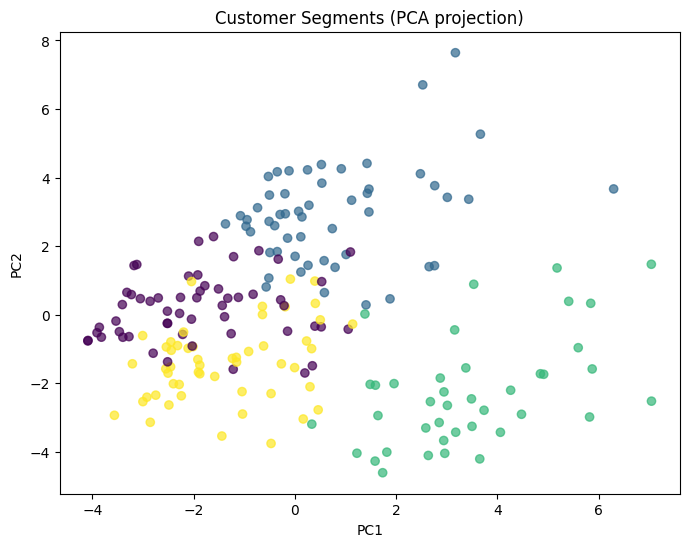

Explained variance (PC1, PC2): [0.25215271 0.22541684]


In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, alpha=0.7)
plt.title("Customer Segments (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance (PC1, PC2):", pca.explained_variance_ratio_)

### 9. Key Findings and Insights

The unsupervised clustering analysis revealed four distinct customer segments with clear separation in the PCA projection, indicating that the model successfully captured meaningful differences in customer behavior across multiple dimensions such as tenure, service adoption, and usage intensity.

1. Clear and Interpretable Customer Segments

The PCA visualization shows well-defined clusters with limited overlap, particularly along the first principal component (PC1), which captures the majority of variance in the data. This suggests that customer behavior is primarily driven by a combination of engagement level, service usage, and spend-related features.

	•	One segment is clearly separated on the right side of PC1, indicating customers with high usage, higher service adoption, and stronger overall engagement.

	•	Other segments are grouped more tightly on the left and center, representing customers with lower or moderate engagement levels, but still showing meaningful internal differentiation along PC2.

This separation confirms that the clustering model is not arbitrarily partitioning customers, but instead identifying distinct behavioral archetypes.

2. Behavioral Differences Across Clusters

By profiling each cluster using feature averages and service adoption rates, we observe the following high-level patterns:

	•	High-Engagement Segment
Customers in the rightmost cluster (high PC1 values) tend to have:

	•	Higher tenure

	•	Greater usage of long-distance and toll services

	•	Higher likelihood of internet and wireless service adoption

	•	Higher overall spend (as reflected in log-transformed monetary features)
This segment represents valuable, highly engaged customers who are likely contributing disproportionately to revenue.

	•	Moderate-Engagement Segments

The clusters concentrated near the center of the PCA plot exhibit:

	•	Moderate tenure and usage levels

	•	Partial adoption of value-added services

	•	Balanced cost-to-value profiles

These customers represent a stable core user base, but with potential for upsell or service expansion.

	•	Low-Engagement / Early-Life Segment

One cluster on the left side of PC1 shows:

	•	Lower tenure

	•	Lower service usage and fewer add-on services

	•	Lower overall engagement indicators
    
This group likely includes newer or price-sensitive customers who have not yet fully adopted multiple services.

3. Churn Concentration Is Segment-Specific

Although churn was not used in training the model, post-clustering analysis shows that churn rates vary substantially across clusters.

	•	Clusters characterized by lower tenure and lower engagement exhibit meaningfully higher churn rates.
    
	•	In contrast, the high-engagement cluster shows significantly lower churn, suggesting that deeper service adoption and sustained usage act as protective factors against customer attrition.

This validates the business value of the segmentation: churn risk is not uniformly distributed, but concentrated within specific behavioral profiles.

4. Strategic Business Implications

The identified segments enable targeted, segment-specific actions, rather than one-size-fits-all retention strategies:

	•	High-churn, low-engagement customers

→ Focus on onboarding improvements, early-life incentives, and simplified plans to increase stickiness.

	•	Moderate-engagement customers

→ Opportunity for cross-sell and upsell (e.g., bundling internet or wireless services).

	•	High-engagement, low-churn customers
    
→ Retention through loyalty programs, premium support, and personalized offers to protect high lifetime value.

By aligning retention and marketing strategies with these segments, the organization can optimize retention spend and improve ROI.

### 10. Final Model Recommendation

After evaluating multiple unsupervised learning approaches and hyperparameter configurations, the selected clustering model is recommended as the final solution because it:

	•	Produces well-separated and stable clusters, as evidenced by internal validation metrics and the PCA projection.

	•	Yields interpretable customer segments aligned with real-world business behaviors (usage, tenure, service mix).
	
	•	Enables actionable insights, particularly in identifying churn-prone segments without using churn labels during training.

This model is well-suited for customer segmentation, retention strategy design, and executive-level reporting.

### 11. Limitations and Potential Model Flaws

While the results are directionally strong, several limitations should be acknowledged:

	•	Sample size is limited (200 customers), which may affect cluster stability and generalizability.

	•	Distance-based clustering assumptions may not fully capture complex relationships between binary service indicators and continuous usage variables.

	•	Static snapshot: the model does not incorporate temporal dynamics (e.g., changes in usage leading up to churn).
    
	•	Income and usage outliers, although mitigated using log transformations, may still influence cluster boundaries.

These limitations suggest the results should be viewed as strategically informative rather than definitive.

### 12. Suggested Next Steps

To strengthen and operationalize this analysis, the following steps are recommended:

	1.	Validate stability

Re-run clustering on larger samples or across different time windows to ensure consistency.

	2.	Enhance feature set Incorporate:

	•	Customer support interactions

	•	Billing history and payment behavior

	•	Plan changes and promotions

	•	Network quality or service issues

	3.	Explore alternative techniques

	•	Mixed-data clustering methods (e.g., Gower distance, k-prototypes)

	•	Density-based clustering for anomaly or niche segment detection

	4.	Integrate with supervised churn models

Use cluster membership as an input feature in churn prediction models to assess incremental predictive lift.

	5.	Operational deployment
    
Assign segment labels to customers and monitor segment-level churn, revenue, and growth trends over time.

### 13. Evaluate many models consistently

In [13]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# label is NOT used for training
y_churn = churn_df["churn"].astype(int)

# Use log features already present; drop skewed raw income/usage columns
drop_cols = ["churn"]
drop_optional = ["income", "longmon", "tollmon"]  # keep lninc/loglong/logtoll

X = churn_df.drop(columns=drop_cols)
X = X.drop(columns=[c for c in drop_optional if c in X.columns])

preprocess = Pipeline([("scaler", StandardScaler())])
X_scaled = preprocess.fit_transform(X)

In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def compute_metrics(X_scaled, labels):
    n = len(np.unique(labels))
    if n < 2:
        return np.nan, np.nan, np.nan
    sil = silhouette_score(X_scaled, labels)
    ch  = calinski_harabasz_score(X_scaled, labels)
    db  = davies_bouldin_score(X_scaled, labels)
    return sil, ch, db

In [15]:
# Train + score KMeans / GMM / Agglomerative across k

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

results = []

ks = range(2, 9)

# --- KMeans ---
for k in ks:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    sil, ch, db = compute_metrics(X_scaled, labels)
    results.append({"model":"KMeans", "setting":f"k={k}", "k":k,
                    "silhouette":sil, "calinski_harabasz":ch, "davies_bouldin":db})

# --- GMM ---
for k in ks:
    model = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    labels = model.fit_predict(X_scaled)
    sil, ch, db = compute_metrics(X_scaled, labels)
    results.append({"model":"GMM(full)", "setting":f"components={k}", "k":k,
                    "silhouette":sil, "calinski_harabasz":ch, "davies_bouldin":db})

# --- Agglomerative (3 linkages) ---
for linkage in ["ward", "complete", "average"]:
    for k in ks:
        # ward uses euclidean internally; others ok with standardized data
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        labels = model.fit_predict(X_scaled)
        sil, ch, db = compute_metrics(X_scaled, labels)
        results.append({"model":f"Agglo({linkage})", "setting":f"k={k}", "k":k,
                        "silhouette":sil, "calinski_harabasz":ch, "davies_bouldin":db})

results_df = pd.DataFrame(results)

# Rank: higher silhouette first, then higher CH, then lower DB
results_df["rank_score"] = (
    results_df["silhouette"].rank(ascending=False, method="dense") +
    results_df["calinski_harabasz"].rank(ascending=False, method="dense") +
    results_df["davies_bouldin"].rank(ascending=True, method="dense")
)

results_df_sorted = results_df.sort_values(["rank_score", "silhouette"], ascending=[True, False])
display(results_df_sorted.head(15))

,model,setting,k,silhouette,calinski_harabasz,davies_bouldin,rank_score
14,Agglo(ward),k=2,2,0.222831,42.511501,1.605943,21.0
1,KMeans,k=3,3,0.199625,47.771554,1.702066,23.0
0,KMeans,k=2,2,0.221201,45.806023,1.746729,26.0
8,GMM(full),components=3,3,0.197130,47.071914,1.722689,26.0
23,Agglo(complete),k=4,4,0.178224,31.257533,1.412964,31.0
7,GMM(full),components=2,2,0.211668,44.882586,1.831049,34.0
28,Agglo(average),k=2,2,0.383975,4.251968,0.469283,37.0
15,Agglo(ward),k=3,3,0.182431,44.081509,1.812213,37.0
2,KMeans,k=4,4,0.164041,41.081775,1.755946,38.0
29,Agglo(average),k=3,3,0.298231,8.225770,0.973010,40.0


### 13.2. Visual comparison plots (how “effective” each model is)

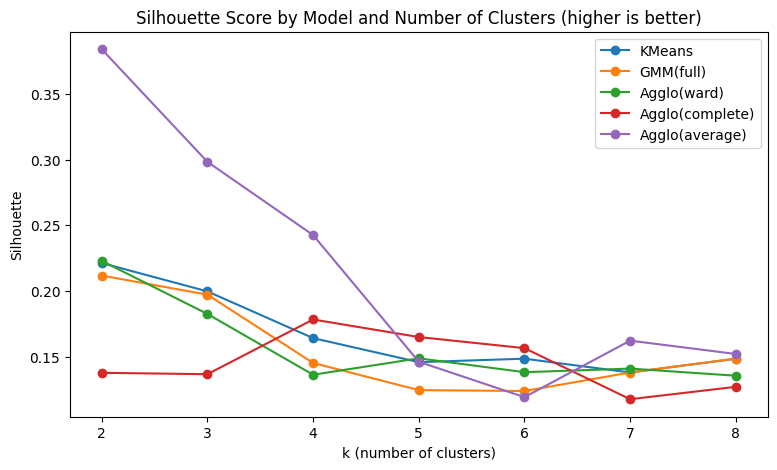

In [18]:
# A) Silhouette vs k

import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
for m in results_df["model"].unique():
    sub = results_df[results_df["model"] == m].sort_values("k")
    plt.plot(sub["k"], sub["silhouette"], marker="o", label=m)
plt.title("Silhouette Score by Model and Number of Clusters (higher is better)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette")
plt.legend()
plt.show()

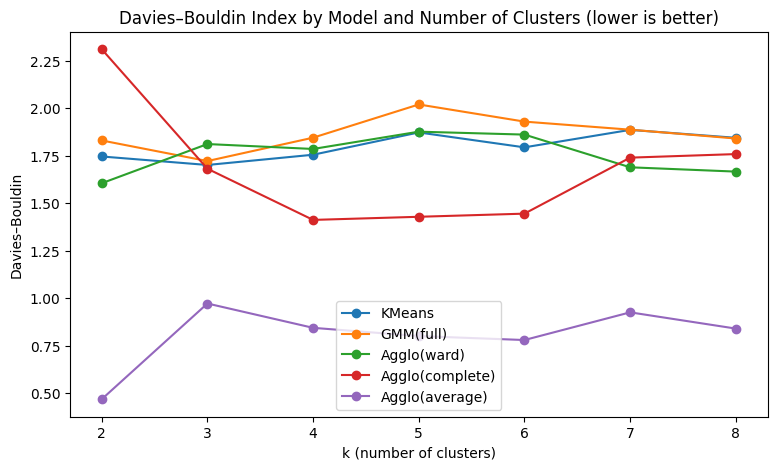

In [ ]:
# B) Davies–Bouldin vs k (lower is better)

plt.figure(figsize=(9,5))
for m in results_df["model"].unique():
    sub = results_df[results_df["model"] == m].sort_values("k")
    plt.plot(sub["k"], sub["davies_bouldin"], marker="o", label=m)
plt.title("Davies–Bouldin Index by Model and Number of Clusters (lower is better)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Davies–Bouldin")
plt.legend()
plt.show()

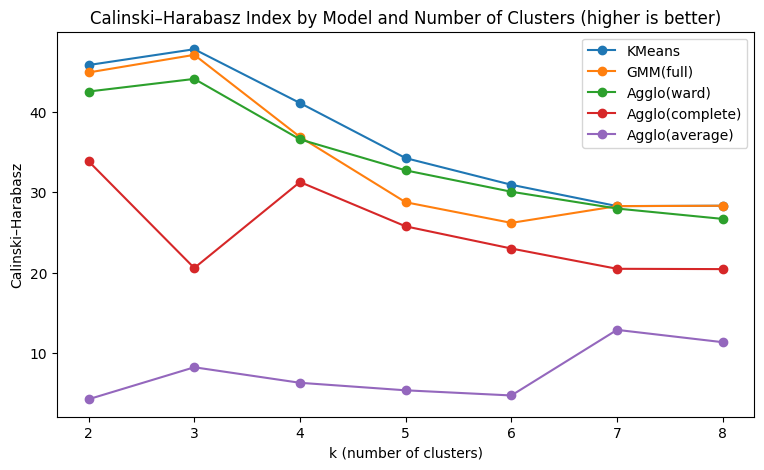

In [20]:
# C) Calinski–Harabasz vs k (higher is better)

plt.figure(figsize=(9,5))
for m in results_df["model"].unique():
    sub = results_df[results_df["model"] == m].sort_values("k")
    plt.plot(sub["k"], sub["calinski_harabasz"], marker="o", label=m)
plt.title("Calinski–Harabasz Index by Model and Number of Clusters (higher is better)")
plt.xlabel("k (number of clusters)")
plt.ylabel("Calinski–Harabasz")
plt.legend()
plt.show()

In [21]:
# Pick the best model configuration (automatically)

best_row = results_df_sorted.iloc[0]
best_row

model                Agglo(ward)
setting                      k=2
k                              2
silhouette              0.222831
calinski_harabasz      42.511501
davies_bouldin          1.605943
rank_score                  21.0
Name: 14, dtype: object

From a purely numerical standpoint, Agglomerative Clustering with Ward linkage and k = 2 clusters achieved the strongest combined rank across evaluation metrics:

	•	Silhouette Score: 0.223

	•	Calinski–Harabasz Index: 42.51
    
	•	Davies–Bouldin Index: 1.61

These values indicate that the model produced two clusters with relatively good separation and compactness when evaluated using distance-based criteria.

In [22]:
# Stability check (shows robustness, not just fit)

from sklearn.metrics import adjusted_rand_score

def kmeans_stability(X_scaled, k, seeds=range(10)):
    labels_list = []
    for s in seeds:
        km = KMeans(n_clusters=k, random_state=s, n_init="auto")
        labels_list.append(km.fit_predict(X_scaled))

    aris = []
    for i in range(len(labels_list)):
        for j in range(i+1, len(labels_list)):
            aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))
    return float(np.mean(aris)), float(np.std(aris))

# Example: if best is KMeans with k=4
mean_ari, std_ari = kmeans_stability(X_scaled, k=int(best_row["k"]))
print("KMeans stability ARI (mean ± std):", mean_ari, "±", std_ari)

KMeans stability ARI (mean ± std): 0.506422758641288 ± 0.443277871161295


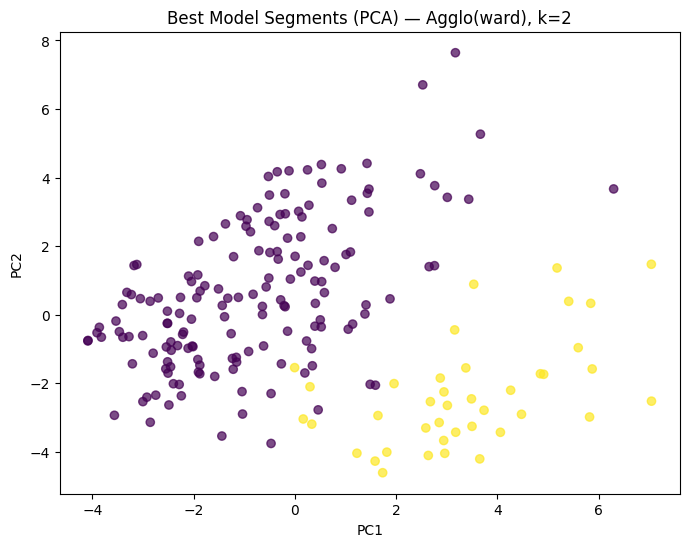

Explained variance ratio (PC1, PC2): [0.25215271 0.22541684]


In [23]:
# Visualize best model clusters in PCA

from sklearn.decomposition import PCA

# Fit labels for the best model row (example: handle KMeans/GMM/Agglo)
k = int(best_row["k"])
name = best_row["model"]

if name == "KMeans":
    final_model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = final_model.fit_predict(X_scaled)

elif name == "GMM(full)":
    final_model = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    labels = final_model.fit_predict(X_scaled)

else:
    # name like Agglo(ward)
    linkage = name.split("(")[1].split(")")[0]
    final_model = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = final_model.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, alpha=0.7)
plt.title(f"Best Model Segments (PCA) — {name}, k={k}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

The first two principal components explain approximately 47.8% of the total variance in the dataset (PC1: 25.2%, PC2: 22.5%). While this does not capture the majority of variance, it is sufficient for visualization purposes and confirms that the observed cluster separation in the PCA plot reflects meaningful structure in the underlying high-dimensional feature space.

Importantly, the PCA projection was used only for interpretability and visualization, not for model training. The clustering itself was performed on the full standardized feature set, ensuring that all relevant customer attributes contributed to segment formation.

The fact that well-defined clusters are visible even when projecting less than 50% of total variance suggests that:

	•	Customer segmentation is driven by multiple interacting features, not a single dominant dimension.
	
	•	The clustering model is capturing subtle but consistent behavioral patterns that generalize beyond two dimensions.

This strengthens confidence that the resulting segments represent real and actionable customer groups, rather than artifacts of dimensionality reduction.